In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.set_logical_device_configuration(
            gpus[0],
            [tf.config.LogicalDeviceConfiguration(memory_limit=4000)])
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)
        
        
import os
import random
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import matplotlib.pyplot as plt
from skimage.io import imread
from tifffile import imsave, imread
from keras.models import Model, Input, load_model
from keras.layers import BatchNormalization, Dropout, LeakyReLU, Dense, Flatten, Activation, ReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalAveragePooling2D
from keras.layers.merge import concatenate, add, multiply
from keras.activations import sigmoid, tanh, relu
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from keras import layers
from tensorflow.keras.layers import Multiply
import matplotlib.pyplot as plt
import time
from IPython import display
from tensorflow.keras import models
from scipy.ndimage import gaussian_filter

1 Physical GPUs, 1 Logical GPUs


In [2]:
def data_generator(GT_image_dr, lowSNR_image_dr, patch_size, n_patches,n_channel, ratio, augment=False, shuffle=False):
    gt = imread(GT_image_dr)
    low = imread(lowSNR_image_dr)
    
    gt = gt.astype(np.float32)
    print(gt.shape)
    gt = gt/gt.max()
    low = low.astype(np.float32)
    low = low/low.max()
    m = gt.shape[0]
    img_size = gt.shape[2]
                 
    x = np.empty((m*n_patches*n_patches, patch_size, patch_size,1), dtype=np.float32)
    y = np.empty((m*n_patches*n_patches, patch_size, patch_size,1), dtype=np.float32)
    
    rr = np.floor(np.linspace(0, img_size - patch_size, n_patches))
    rr = rr.astype(np.int32)
    cc = rr
    
    count = 0
#     for j in range(n_patches):
#         for k in range(n_patches):
#             for l in range(m):
#                 for i in range(1):
#                     x[count*m:(count+1)*m,:,:,i] = low[l,0,rr[j]:rr[j] + patch_size, cc[k]:cc[k] + patch_size]
#                     y[count*m:(count+1)*m,:,:,i] = gt[l,0,rr[j]:rr[j] + patch_size, cc[k]:cc[k] + patch_size]
#                 count = count + 1

    for j in range(n_patches):
        for k in range(n_patches):
            for l in range(m):
                for i in range(1):
                    x[count*m:(count+1)*m,:,:,i] = low[l,rr[j]:rr[j] + patch_size, cc[k]:cc[k] + patch_size]
                    y[count*m:(count+1)*m,:,:,i] = gt[l,rr[j]:rr[j] + patch_size, cc[k]:cc[k] + patch_size]
                count = count + 1

    if augment:
        count = x.shape[0]
        xx = np.zeros((4 * count, patch_size, patch_size,1), dtype=np.float32)
        yy = np.zeros((4 * count, patch_size, patch_size,1), dtype=np.float32)

        xx[0:count, :, :, :] = x
        xx[count:2 * count, :, :, :] = np.flip(x, axis=1)
        xx[2 * count:3 * count, :, :, :] = np.flip(x, axis=2)
        xx[3 * count:4 * count, :, :, :] = np.flip(x, axis=(1, 2))

        yy[0:count, :, :, :] = y
        yy[count:2 * count, :, :, :] = np.flip(y, axis=1)
        yy[2 * count:3 * count, :, :, :] = np.flip(y, axis=2)
        yy[3 * count:4 * count, :, :, :] = np.flip(y, axis=(1, 2))
    else:
        xx = x
        yy = y
        
    norm_x = np.linalg.norm(yy,axis=(1,2))
    ind_norm = np.where(norm_x>15)[0]
    
    xxx = np.empty((len(ind_norm), xx.shape[1], xx.shape[2], xx.shape[3]))
    yyy = np.empty((len(ind_norm), xx.shape[1], xx.shape[2], xx.shape[3]))
    
    for i in range(len(ind_norm)):
        xxx[i] = xx[ind_norm[i]]
        yyy[i] = yy[ind_norm[i]]


    aa = np.linspace(0, len(xxx) - 1, len(xxx))
    random.shuffle(aa)
    aa = aa.astype(int)

    xxs = np.empty(xxx.shape, dtype=np.float32)
    yys = np.empty(yyy.shape, dtype=np.float32)
    

    if shuffle:
        for i in range(len(xxx)):
            xxs[i] = xxx[aa[i]]
            yys[i] = yyy[aa[i]]
    else:
        xxs = xxx
        yys = yyy
        
#     xxs = 0.5*np.random.poisson(lam=0.1,size=yys.shape)+0.1*np.random.normal(0,0.1,size=yys.shape)+0.5*yys
#     xxs[xxs<0] = 0
#     xxs = gaussian_filter(xxs, sigma=1.0)
    
    for i in range(len(xxs)):
        xxs[i]=xxs[i]/xxs[i].max()
        if yys[i].max()>0:
            yys[i]=yys[i]/yys[i].max()
            
    
    n_batch_c = int(np.floor(len(xxs)/n_channel))
    xxs1 = np.empty((n_batch_c,xxs.shape[1],xxs.shape[2],n_channel), dtype=np.float32)
    yys1 = np.empty((n_batch_c,xxs.shape[1],xxs.shape[2],n_channel), dtype=np.float32)


    for j in range(n_channel):
        xxs1[0:n_batch_c,:,:,j] = xxs[j*n_batch_c:(j+1)*n_batch_c,:,:,0]
        yys1[0:n_batch_c,:,:,j] = yys[j*n_batch_c:(j+1)*n_batch_c,:,:,0]
        
    
        

    # Split train and valid
    ratio = ratio
    m1 = np.floor(xxs1.shape[0] * ratio).astype(np.int32)
    x_train = xxs1[0:m1]
    y_train = yys1[0:m1]
    # x_train = xxs
    # y_train = yys
    x_valid = xxs1[m1::]
    y_valid = yys1[m1::]


    # x_train = x_train.reshape(x_train.shape+(1,))
    # y_train = y_train.reshape(y_train.shape+(1,))
    # x_valid = x_valid.reshape(x_valid.shape+(1,))
    # y_valid = y_valid.reshape(y_valid.shape+(1,))

    print('The training set shape is:', x_train.shape)
    print('The validation set shape is:', x_valid.shape)
    return x_train, y_train, x_valid, y_valid

In [3]:
# w_init = tf.keras.initializers.GlorotUniform()
w_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05)


def CAB(inputs, filters_cab, filters, kernel,dropout):
    x = GlobalAveragePooling2D(data_format='channels_last',keepdims=True)(inputs)
    x = Conv2D(filters=filters_cab, kernel_size=kernel, kernel_initializer=w_init, padding="same")(x)
    x = Dropout(dropout)(x)
    x = relu(x)
    x = Conv2D(filters=filters, kernel_size=kernel, kernel_initializer=w_init, padding="same")(x)
    x = Dropout(dropout)(x)
    x = sigmoid(x)
    #x = relu(x)
    x = multiply([x, inputs])
    return x


def RCAB(inputs, filters, filters_cab, kernel, dropout):
    x = Conv2D(filters=filters, kernel_size=kernel, kernel_initializer=w_init, padding="same")(inputs)
    x = Dropout(dropout)(x)
    x = relu(x)
    x = Conv2D(filters=filters, kernel_size=kernel, kernel_initializer=w_init, padding="same")(x)
    x = CAB(x, filters_cab, filters, kernel=(1, 1),dropout=dropout)
    x = Dropout(dropout)(x)
    x = add([x, inputs])
    return x


def RG(inputs, num_blocks, filters, filters_cab, kernel, dropout):
    x = inputs
    for i in range(num_blocks):
        x = RCAB(x, filters, filters_cab, kernel, dropout)
    x = Conv2D(filters=filters, kernel_size=kernel, kernel_initializer=w_init, padding="same")(x)
    x = Dropout(dropout)(x)
    x = add([x, inputs])
    return x


def RiR(inputs, num_RG, num_RCAB, filters, filters_cab, kernel, dropout):
    x = inputs
    for i in range(num_RG):
        x = RG(x, num_RCAB, filters, filters_cab, kernel, dropout)
    x = Conv2D(filters=filters, kernel_size=kernel, kernel_initializer=w_init, padding="same")(x)
    x = Dropout(dropout)(x)
    x = add([x, inputs])
    return x


def make_RCAN(inputs, filters, filters_cab, num_RG, num_RCAB, kernel,n_channel, dropout):
    x = Conv2D(filters=filters, kernel_size=kernel, kernel_initializer=w_init, padding="same")(inputs)
    x = RiR(x, num_RG, num_RCAB, filters, filters_cab, kernel, dropout)
    x = Dropout(dropout)(x)
    x = Conv2D(filters=1, kernel_size=kernel, kernel_initializer=w_init, padding="same")(x)
    model = Model(inputs=[inputs], outputs=[x])
    return model

In [4]:
mse = tf.keras.losses.MeanSquaredError(reduction='sum_over_batch_size')
def norm_mse_loss(prediction, gt):
    n_mse = mse(prediction,gt)
    norm_mse = tf.squeeze(n_mse)    
    return norm_mse


def fft_loss(prediction, gt):
    prediction = tf.transpose(prediction, perm=[0, 3, 1, 2])
    gt = tf.transpose(gt, perm=[0, 3, 1, 2])

    fft_prediction = tf.signal.fftshift(tf.signal.rfft2d(prediction))
    fft_gt = tf.signal.fftshift(tf.signal.rfft2d(gt))

    fft_prediction = tf.abs(tf.transpose(fft_prediction, perm=[0, 2, 3, 1]))
    fft_prediction = tf.cast(fft_prediction, tf.float32)
    fft_gt = tf.abs(tf.transpose(fft_gt, perm=[0, 2, 3, 1]))
    fft_gt = tf.cast(fft_gt, tf.float32)

    loss = norm_mse_loss(fft_prediction, fft_gt)
    # loss = tf.cast(loss, tf.float32)
    return loss


def ssim_loss(prediction, gt):
    loss = 1.0 - tf.math.reduce_mean(tf.image.ssim(prediction, gt, max_val=1))
    return loss


def perceptual_loss(prediction, gt):
    loss = 0
    prediction = tf.image.grayscale_to_rgb(prediction)
    gt = tf.image.grayscale_to_rgb(gt)
    for m in range(len(LL)):
        vgg_prediction = inter_vgg[m](prediction)
        vgg_gt = inter_vgg[m](gt)
        loss = loss + norm_mse_loss(vgg_prediction, vgg_gt)
    return loss



def generator_loss(prediction, gt):
#     percept_loss = perceptual_loss(prediction, gt)
#     sim_loss = ssim_loss(prediction, gt)
#     ft_loss = fft_loss(prediction, gt)
    norm_mse = norm_mse_loss(prediction, gt)
#     gen_loss = 5000 * percept_loss + 5 * sim_loss + 15 * norm_mse + 100 * ft_loss
    gen_loss = norm_mse
    return gen_loss

In [5]:
@tf.function
def train_step(input_image, target, generator, generator_optimizer):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)
        gen_loss = generator_loss(gen_output, target)

    generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    return gen_loss


def train(gen_model, gen_opt, inputs, gt, inputs_valid, gt_valid, n_epochs,
          model_save_directory,
          loss_save_directory, x_valid1, y_valid1):
    value_loss = np.zeros((n_epochs, 2))
    count1 = 0

    for epoch in range(n_epochs):
        start = time.time()
        count = 1
        for x_train, y_train in zip(inputs, gt):
            gen_loss = train_step(x_train, y_train, gen_model, gen_opt)
            value_loss[epoch, 0] = gen_loss.numpy() + value_loss[epoch, 0]
            count = count + 1

        value_loss[epoch, 0] = value_loss[epoch, 0] / count

        count = 1
        for x_valid, y_valid in zip(inputs_valid, gt_valid):
            prediction_valid = gen_model(x_valid, training=False)
            gen_loss = generator_loss(prediction_valid, y_valid)
            value_loss[epoch, 1] = gen_loss.numpy() + value_loss[epoch, 1]
            count = count + 1
        value_loss[epoch, 1] = value_loss[epoch, 1] / count

        display.clear_output(wait=True)

        # current_lr = 10**(-10+epoch/10)
        # tf.keras.backend.set_value(gen_model.optimizer.learning_rate, current_lr)
        # print('learning rate:', current_lr)
        # lr_max = 1e-5
        # lr_min = 1e-8
        # period = 40
        # current_lr = lr_min+1/2*(lr_max-lr_min)*(1+np.cos(np.pi*np.mod(epoch,period)/period))
        # tf.keras.backend.set_value(gen_model.optimizer.learning_rate, current_lr)
        # print('learning rate:', current_lr)

        current_lr = tf.keras.backend.eval(gen_model.optimizer.lr)
        print('learning rate:', current_lr)
        # if np.remainder(count1 + 1, 10) == 0:
        #     if current_lr > 1e-8:
        #         update_lr = current_lr * 0.5
        #         tf.keras.backend.set_value(gen_model.optimizer.learning_rate, update_lr)
        if np.remainder(epoch + 1, 20) == 0:
            if current_lr > 1e-8:
                update_lr = current_lr * 0.2
                tf.keras.backend.set_value(gen_model.optimizer.learning_rate, update_lr)
        
        if epoch == 0:
            gen_model.save_weights(model_save_directory, overwrite=True)
            print('model is saved')
        else:
            if value_loss[epoch, 1] <= np.min(value_loss[0:epoch, 1]):
                gen_model.save_weights(model_save_directory, overwrite=True)
                print('model is saved')
                count1 = 0
            else:
                count1 = count1 + 1
        # if count1 == 100:
        #     print('Training is stopped')
        #     break

        np.savetxt(loss_save_directory, value_loss, delimiter=",")

        print('>%d, g[%.3f] v[%.3f]' % (epoch + 1, value_loss[epoch, 0], value_loss[epoch, 1]))
        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))


        ix = random.randint(0, len(x_valid1)-1)
        predictions = gen_model(x_valid1[ix:ix + 1], training=False)
        
        fig = plt.figure(figsize=(20, 15))
        plt.subplot(1, 3, 1)
        plt.imshow(x_valid1[ix, :, :, 0], cmap='magma')
        plt.axis('off')
        plt.subplot(1, 3, 2)
        plt.imshow(predictions[0, :, :, 0], cmap='magma')
        plt.axis('off')
        plt.subplot(1, 3,3)
        plt.imshow(y_valid1[ix, :, :, 0], cmap='magma')
        plt.axis('off')
        plt.show()
    return value_loss

In [6]:
GT_image_dr = r'D:\Models\Data generator\STED-Histon-Microtubule\20frame\train\Average.tif'
lowSNR_image_dr = r'D:\Models\Data generator\STED-Histon-Microtubule\20frame\train\1frame.tif'
patch_size = 256
n_patches = 10
n_channel = 1


model_save_directory = r"D:\Models\Data generator\STED-Histon-Microtubule\20frame\model-rcan-tubulin.h5"
loss_save_directory = r"D:\Models\Data generator\STED-Histon-Microtubule\20frame\model-rcan-tubulin.csv"
n_epochs = 300
batch_size = 4



vgg = tf.keras.applications.VGG16(include_top=False, weights='imagenet',
                                  input_tensor=Input(shape=(patch_size,patch_size,3)))

inter_vgg = []
LL = [2, 5, 9, 13, 17]
for i in LL:
    inter_vgg.append(Model(inputs=vgg.input, outputs=vgg.get_layer(vgg.layers[i].name).output))

In [7]:
x_train, y_train, x_valid, y_valid = data_generator(GT_image_dr, lowSNR_image_dr, patch_size, n_patches,ratio=0.99,
                                                    n_channel=n_channel,
                                                    augment=False, shuffle=True)

train_x_dataset = tf.data.Dataset.from_tensor_slices(x_train).batch(batch_size)
train_y_dataset = tf.data.Dataset.from_tensor_slices(y_train).batch(batch_size)
valid_x_dataset = tf.data.Dataset.from_tensor_slices(x_valid).batch(batch_size)
valid_y_dataset = tf.data.Dataset.from_tensor_slices(y_valid).batch(batch_size)

(18, 2048, 2048)
The training set shape is: (1300, 256, 256, 1)
The validation set shape is: (14, 256, 256, 1)


6


(-0.5, 255.5, 255.5, -0.5)

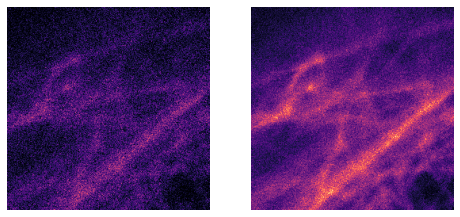

In [8]:
ix = np.random.randint(0,len(x_valid))
ic = np.random.randint(0,n_channel)
#ix = 10
print(ix)
fig = plt.figure(figsize = (8,8))
plt.subplot(1, 2, 1)
plt.imshow(x_valid[ix,:,:,ic].squeeze() , cmap='magma')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(y_valid[ix,:,:,ic].squeeze() , cmap='magma')
plt.axis('off')

In [9]:
filters = 32
filters_cab = 4
num_RG = 5
num_RCAB = 3
gen_lr = 1e-4


rcan_input = Input((patch_size, patch_size,n_channel))
rcan = make_RCAN(rcan_input, filters, filters_cab, num_RG, num_RCAB, kernel=(3, 3),n_channel=n_channel, dropout=0.1)
gen_opt = keras.optimizers.Adam(learning_rate=gen_lr, epsilon=1e-8)
rcan.compile(optimizer=gen_opt, loss=generator_loss)

In [ ]:
rcan.summary()

learning rate: 6.3999996e-09
>226, g[0.005] v[0.004]
Time for epoch 226 is 36.68849968910217 sec


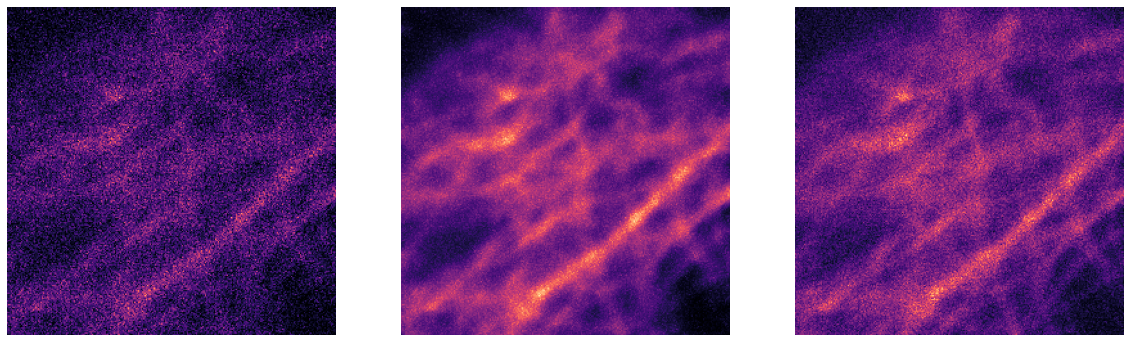

In [ ]:
loss_value = train(rcan, gen_opt, train_x_dataset, train_y_dataset, valid_x_dataset,
                   valid_y_dataset, n_epochs, model_save_directory, loss_save_directory, x_valid, y_valid)

In [ ]:
# callbacks = [
#     EarlyStopping(patience=100 ,verbose=1),
#     ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15,verbose=1, min_lr=1e-8),
#     ModelCheckpoint(filepath=model_save_directory, verbose=1, save_best_only=True, save_weights_only=True)
# ]

def scheduler(epoch,lr):
    if np.mod(epoch+1,50)==0:
        lr = lr*0.6
        return lr
    else:
        return lr

callbacks = [
    LearningRateScheduler(scheduler),
    ModelCheckpoint(filepath=model_save_directory, verbose=1, save_best_only=True, save_weights_only=True)
]

opt = keras.optimizers.Adam(learning_rate=gen_lr)
rcan.compile(optimizer=opt, loss=generator_loss, metrics='mse')

In [ ]:
results = rcan.fit(x=x_train, y=y_train, batch_size=1, epochs=800,
                      verbose=1, callbacks=callbacks, validation_split=0.1)

In [ ]:
model_save_directory = r"D:\Models\Data generator\STED-Histon-Microtubule\20frame\model-rcan-tubulin.h5"

test_GT = r'D:\Models\Data generator\STED-Histon-Microtubule\20frame\test\Average.tif'
test_low = r'D:\Models\Data generator\STED-Histon-Microtubule\20frame\test\1frame.tif'
test_patch_size=1024 
n_test_patch=3

filters = 32
filters_cab = 4
num_RG = 5
num_RCAB = 3


x_test, y_test,_,_ = data_generator(test_GT, test_low, test_patch_size, n_test_patch,ratio=0.99,
                                                    n_channel=n_channel,
                                                    augment=False, shuffle=True)

generator_input = Input((test_patch_size, test_patch_size, 1))
generator1 = make_RCAN(generator_input, filters, filters_cab, num_RG, num_RCAB, kernel=(3, 3),n_channel=n_channel, dropout=0.3)
generator1.load_weights(model_save_directory)

prediction = np.zeros(x_test.shape)
print(prediction.shape)
for i in range(len(x_test)):
    prediction[i] = generator1(x_test[i:i+1],training=False)
for i in range(1):
    prediction[:,:,:,i] = prediction[:,:,:,i]/prediction[:,:,:,i].max()

In [ ]:
ix = np.random.randint(0,len(prediction))
ic = np.random.randint(0,n_channel)
print(ix)
#ix = 8
fig = plt.figure(figsize=(20, 15))
plt.subplot(1, 3, 1)
plt.imshow(x_test[ix, :, :, ic], cmap='magma')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(prediction[ix, :, :, ic], cmap='magma')
plt.axis('off')
plt.subplot(1, 3,3)
plt.imshow(y_test[ix, :, :, ic], cmap='magma')
plt.axis('off')

In [ ]:
x_test1 = np.zeros((x_test.shape[0],2,x_test.shape[1],x_test.shape[2]),dtype=np.float32)
y_test1 = np.zeros((x_test.shape[0],2,x_test.shape[1],x_test.shape[2]),dtype=np.float32)
prediction1 = np.zeros((x_test.shape[0],2,x_test.shape[1],x_test.shape[2]),dtype=np.float32)
for i in range(2):
    x_test[:,:,:,i] = x_test[:,:,:,i]/x_test[:,:,:,i].max()
    x_test1[:,i,:,:]=x_test[:,:,:,i]
    y_test1[:,i,:,:]=y_test[:,:,:,i]
    prediction1[:,i,:,:]=prediction[:,:,:,i]

In [ ]:
from tifffile import imwrite
save_image_dr = r"C:\Users\va332845\OneDrive - Knights - University of Central Florida\Nanoscopy Group\Experiments\Deep Learning-Fast Wide Field\20220329\_1\test" 
prediction1 = prediction1*(2**16-1)
x_test1 = x_test1*(2**16-1)
y_test1 = y_test1*(2**16-1)

prediction1 = prediction1.astype(np.uint16)
x_test1 = x_test1.astype(np.uint16)
y_test1 = y_test1.astype(np.uint16)

imwrite(os.path.join(save_image_dr,'prediction1.tif'), prediction1, imagej=True)
imwrite(os.path.join(save_image_dr,'lowSNR1.tif'), x_test1, imagej=True)
imwrite(os.path.join(save_image_dr,'GT1.tif'), y_test1, imagej=True)